In [727]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

N: int = 3
NAV: float = 43_964.16
TARGET_LEVERAGE: float = 2.20
LEVERAGE: np.ndarray = np.array(
    [
        [1.00],
        [2.00],
        [3.00]
    ]
)
EXPENSE_RATIOS: np.ndarray = np.array(
    [
        [0.0002],  # SPLG
        [0.0061],  # SPUU
        [0.0091]   # UPRO 
    ]
)
EXPENSE_RATIO_ADJUSTED_LEVERAGE: np.ndarray = LEVERAGE - EXPENSE_RATIOS

In [642]:
import copy 


def relu_upper_bound(x: np.ndarray, bound: float) -> np.ndarray:

    relu = np.dot(np.transpose(x), np.ones(np.shape(x))) - bound
    
    return np.log(relu) if relu > 0.00 else 0.00


def relu_upper_bound_gradient(x: np.ndarray, bound: float) -> np.ndarray:

    relu = np.dot(np.transpose(x), np.ones(np.shape(x))) - bound
    
    return 1 / x if relu > 0.00 else 0.00


def element_wise_relu_lower_bound(x: np.ndarray, bound: float) -> np.ndarray:

    x = copy.deepcopy(x)

    inactive_index = np.where(x >= bound)
    active_index = np.where(x < bound)
    
    x[inactive_index] = 0
    x[active_index] = np.log(-x[active_index])
    
    return x


def element_wise_relu_lower_bound_gradient(x: np.ndarray, bound: float) -> np.ndarray:

    x = copy.deepcopy(x)

    inactive_index = np.where(x >= bound)
    active_index = np.where(x < bound)
    
    x[inactive_index] = 0
    x[active_index] = 1 / -x[active_index]
    
    return x


def min_t_cost_constrained_optimizer(
    weights: np.ndarray, 
    leverage: np.ndarray, 
    expense_ratios: np.ndarray,
    learning_rate: float = 0.001,
    n_iterations: int = 200_000,
    bound_penalty: float = 0.01,
    stochastic_factor: float = 0.00
) -> np.ndarray:
    
    weights_evolution = []
    objective_evolution = []
    
    for i in range(n_iterations):
        
        objective = (
            np.dot(np.transpose(weights), expense_ratios)
            + np.square(np.dot(np.transpose(weights), leverage) - TARGET_LEVERAGE)
            - bound_penalty *  relu_upper_bound(x=weights, bound=1)
            - bound_penalty * np.dot(np.transpose(element_wise_relu_lower_bound(x=weights, bound=0)), np.ones(np.shape(weights)))
        )
        objective_evolution.append(objective[0][0])

        gradient = (
            expense_ratios
            + 2 * (np.dot(np.transpose(weights), leverage) - TARGET_LEVERAGE) * leverage
            + bound_penalty * relu_upper_bound_gradient(x=weights, bound=1)  # add to gradient which will be subtracted from weights - go back below upper bound
            - bound_penalty * element_wise_relu_lower_bound_gradient(x=weights, bound=0)  # subtract from gradient which will be added to weights - go back above lower bound
        )

        # Simulate a noisy gradient - decrease the magnitude of the noise over time
        gradient = gradient + np.random.normal(
            loc=0.0, 
            scale=stochastic_factor * (1 - i / n_iterations) * np.mean(np.abs(gradient)), size=np.shape(weights)
        )
        
        weights = weights - learning_rate * gradient

        weights_evolution.append(weights)
    
    pd.Series(objective_evolution).plot()
    plt.show()

    return weights_evolution[np.argmin(objective_evolution)], np.min(objective_evolution)

# Randomized Optimization

In [640]:
n_random_initial_weights: int = 10
random_initial_weights = np.random.uniform(low=0, high=1, size=(n_random_initial_weights, 3))
random_initial_weights /= np.reshape(np.sum(random_initial_weights, axis=1), newshape=(n_random_initial_weights, 1))
random_initial_weights /= 2
random_initial_weights

array([[0.17595714, 0.0857413 , 0.23830156],
       [0.26697216, 0.12633549, 0.10669235],
       [0.41218709, 0.06638956, 0.02142336],
       [0.26252757, 0.23187338, 0.00559905],
       [0.22719338, 0.11161694, 0.16118968],
       [0.11421568, 0.23078829, 0.15499603],
       [0.27505094, 0.02314721, 0.20180185],
       [0.06187288, 0.28098674, 0.15714038],
       [0.15027537, 0.11578082, 0.23394381],
       [0.24514715, 0.18916608, 0.06568677]])

To mitigate the effects of local minima, randomize a panel of initial weights, and run the optimization for each random initial weights vector. 

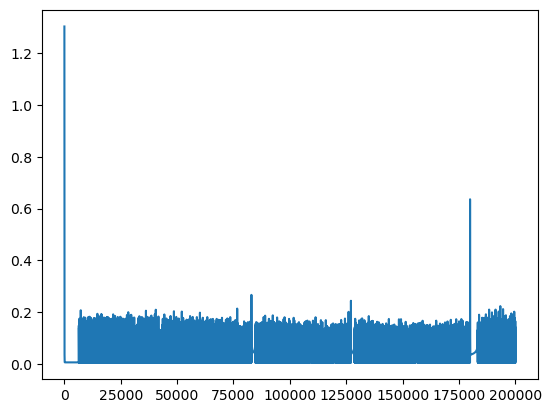

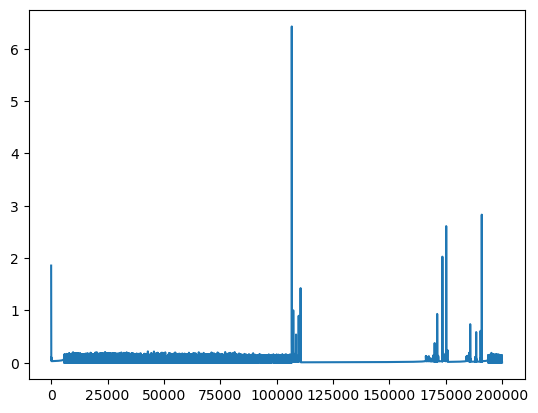

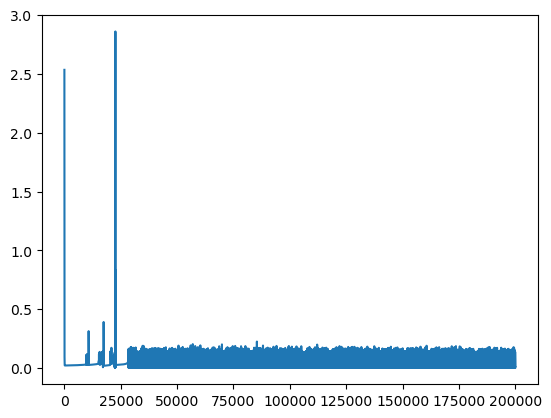

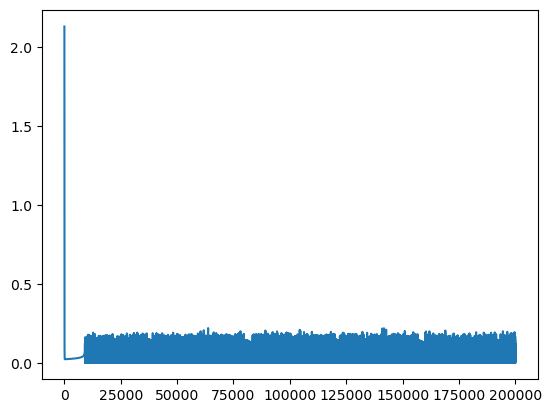

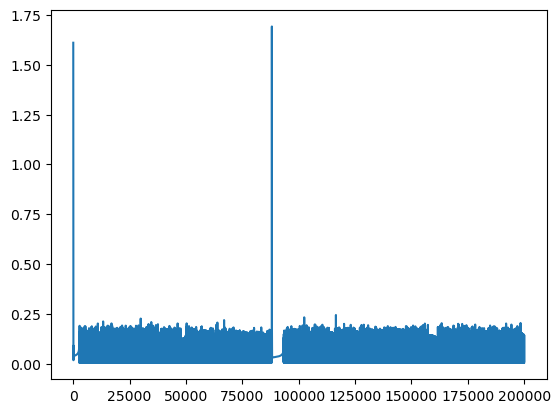

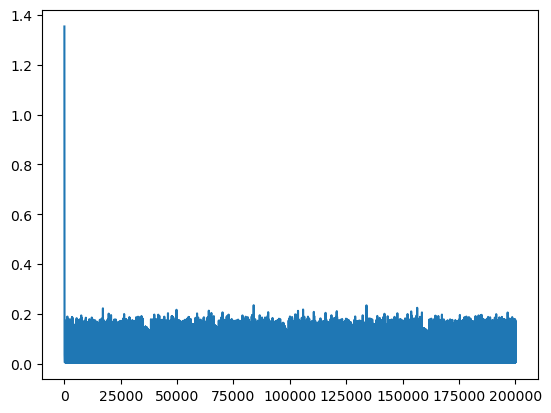

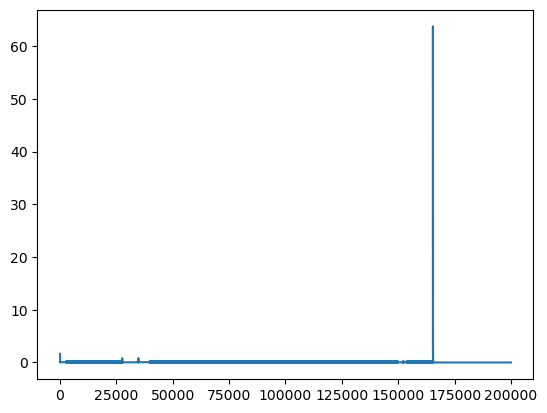

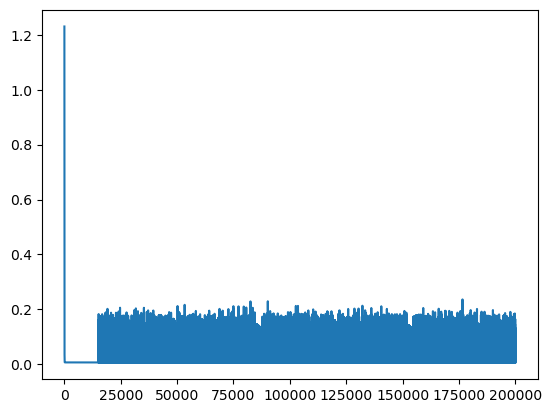

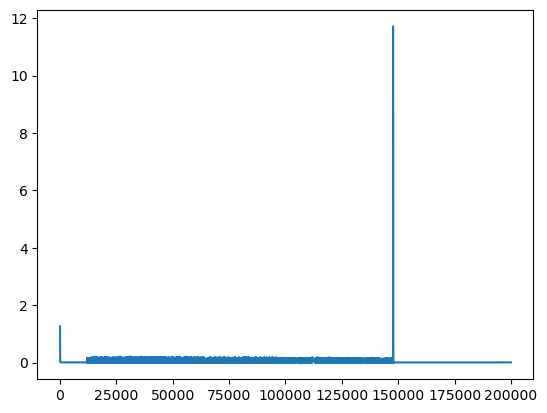

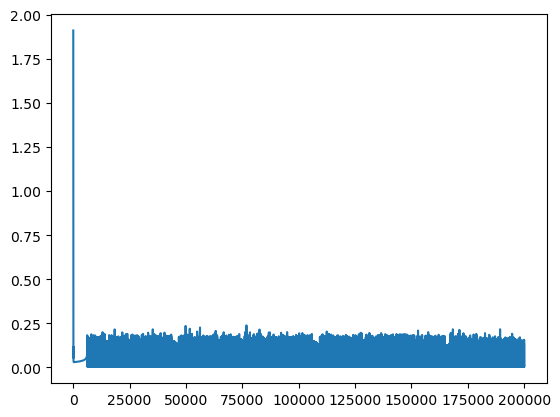

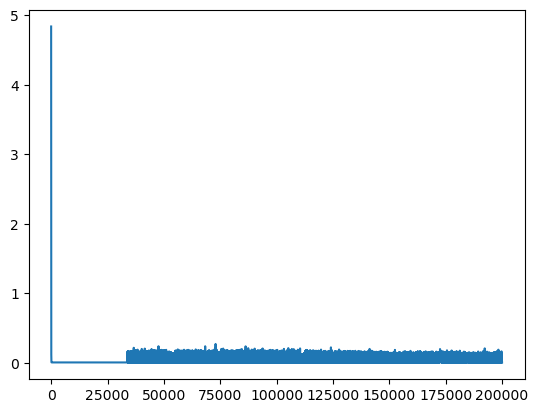

In [695]:
solution_weights = []
solution_objectives = []

for i, random_initial_weights_i in enumerate(random_initial_weights):

    random_initial_weights_i = np.reshape(random_initial_weights_i, newshape=(-1, 1))
    
    solution_weights_i, solution_objective_i = min_t_cost_constrained_optimizer(
        weights=random_initial_weights_i, 
        leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
        expense_ratios=EXPENSE_RATIOS
    )

    if np.any(solution_weights_i < 0):
        continue

    solution_weights.append(solution_weights_i.flatten())
    solution_objectives.append(solution_objective_i)

solution_weights_i, solution_objective_i = min_t_cost_constrained_optimizer(
    weights=np.array([[0.00], [0.00], [0.00]]), 
    leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
    expense_ratios=EXPENSE_RATIOS
)

solution_weights.append(solution_weights_i.flatten())
solution_objectives.append(solution_objective_i)

solution_weights = pd.DataFrame(solution_weights)
solution_weights

In [707]:
solution_weights = pd.DataFrame(solution_weights)
solution_weights

,0,1,2
0,0.397932,0.000159,0.601910
1,0.397644,0.000610,0.601748
2,0.399699,0.001938,0.598394
3,0.201926,0.391782,0.406297
4,0.397432,0.001095,0.601475
5,0.290562,0.214883,0.494555
6,0.222769,0.350183,0.427051
7,0.378387,0.039532,0.582087
8,0.397894,0.000137,0.601969


In [712]:
index = np.where(np.array(solution_objectives) > 0)

filtered_solution_objectives = np.array(solution_objectives)[index]
filtered_solution_weights = solution_weights.iloc[index]

filtered_solution_weights

,0,1,2
0,0.397932,0.000159,0.601910
1,0.397644,0.000610,0.601748
2,0.399699,0.001938,0.598394
3,0.201926,0.391782,0.406297
4,0.397432,0.001095,0.601475
5,0.290562,0.214883,0.494555
6,0.222769,0.350183,0.427051
7,0.378387,0.039532,0.582087
8,0.397894,0.000137,0.601969


In [724]:
optimal_weights = filtered_solution_weights.iloc[np.argmin(filtered_solution_weights.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE))]

In [725]:
optimal_weights.dot(LEVERAGE)[0]

2.198756818852375

In [731]:
optimal_dollar_weights = NAV * optimal_weights.round(2)
optimal_dollar_weights

0    17585.664
1        0.000
2    26378.496
Name: 2, dtype: float64

# Manual Optimization

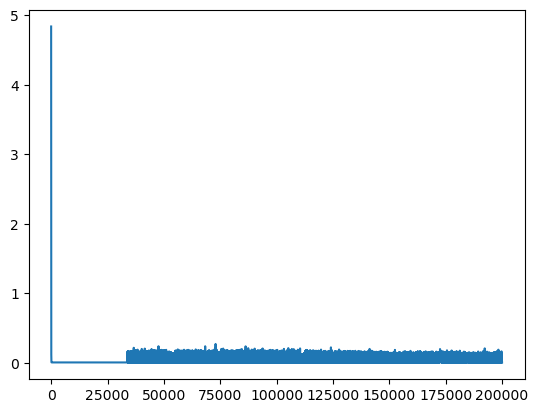

AttributeError: 'tuple' object has no attribute 'sum'

In [718]:
learning_rate: float = 0.001

weights = min_t_cost_constrained_optimizer(
    weights=np.array([[0.0], [0.0], [0.0]]), 
    leverage=EXPENSE_RATIO_ADJUSTED_LEVERAGE, 
    expense_ratios=EXPENSE_RATIOS,
    learning_rate=learning_rate
)
weights, weights.sum(), weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE), weights.T.dot(EXPENSE_RATIOS)

In [501]:
weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE)

array([[2.19857838]])

In [502]:
weights.T.dot(EXPENSE_RATIOS)

array([[0.00557384]])

In [458]:
manual_weights = np.array(
    [
        [0.35],
        [0.0],
        [0.62]
    ]
)

manual_weights.T.dot(EXPENSE_RATIO_ADJUSTED_LEVERAGE), manual_weights.T.dot(EXPENSE_RATIOS)

(array([[2.204288]]), array([[0.005712]]))